In [2]:
import sys
sys.path.append("../scripts")
from timeseries_model import (
 prepare_data, run_arima, run_lstm, evaluate_performance,forecast_future_lstm
)

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import EfficientFrontier

In [4]:
full_df = pd.read_csv("../data/processed/market_data_processed.csv", parse_dates=["Date"])

In [5]:
#["TSLA", "BND", "SPY"]
train_tsla, test_tsla = prepare_data(full_df, asset_name='TSLA')
train_bnd, test_bnd = prepare_data(full_df, asset_name='BND')
train_spy, test_spy = prepare_data(full_df, asset_name='SPY')

print(f"TSLA training set size: {len(train_tsla)}")
print(f"TSLA testing set size: {len(test_tsla)}")
print("---------------------------------")
print(f"BND training set size: {len(train_bnd)}")
print(f"BND testing set size: {len(test_bnd)}")
print("---------------------------------")
print(f"SPY training set size: {len(train_spy)}")
print(f"SPY testing set size: {len(test_spy)}")

TSLA training set size: 2516
TSLA testing set size: 259
---------------------------------
BND training set size: 2516
BND testing set size: 259
---------------------------------
SPY training set size: 2516
SPY testing set size: 259


2. Run ARIMA Model

In [11]:
arima_forecast, arima_order = run_arima(train_tsla, test_tsla)
print(f"TSLA optimal ARIMA Order: {arima_order}")

bnd_arima_forecast, arima_order = run_arima(train_bnd, test_bnd)
print(f"BND optimal ARIMA Order: {arima_order}")

spy_arima_forecast, arima_order = run_arima(train_spy, test_spy)
print(f"SPY optimal ARIMA Order: {arima_order}")

# Evaluate ARIMA
arima_metrics = evaluate_performance(test_tsla, arima_forecast)
print("TSLA ARIMA Performance:", arima_metrics)

bnd_arima_metrics = evaluate_performance(test_bnd, bnd_arima_forecast)
print("BND ARIMA Performance:", bnd_arima_metrics)

spy_arima_metrics = evaluate_performance(test_spy, spy_arima_forecast)
print("SPY ARIMA Performance:", spy_arima_metrics)

c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure

TSLA optimal ARIMA Order: (0, 1, 0)


c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure

BND optimal ARIMA Order: (2, 1, 2)


c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure

SPY optimal ARIMA Order: (1, 1, 0)
TSLA ARIMA Performance: {'MAE': 69.4989569233191, 'RMSE': np.float64(82.93461282588196), 'MAPE': np.float64(22.557915255182202)}
BND ARIMA Performance: {'MAE': 2.814402155031798, 'RMSE': np.float64(3.2462984426306614), 'MAPE': np.float64(3.8624866574505736)}
SPY ARIMA Performance: {'MAE': 51.368423277337456, 'RMSE': np.float64(62.37769877162785), 'MAPE': np.float64(8.018257001494469)}


c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(

3. Run LSTM Model

In [12]:
# Note: This might take a minute depending on your GPU/CPU
lstm_forecast, my_lstm_model, my_scaler= run_lstm(train_tsla, test_tsla, window_size=60)
bnd_lstm_forecast, bnd_my_lstm_model, bnd_scaler= run_lstm(train_bnd, test_bnd, window_size=60)
spy_lstm_forecast, spy_my_lstm_model, spy_scaler= run_lstm(train_spy, test_spy, window_size=60)


# Evaluate LSTM
lstm_metrics = evaluate_performance(test_tsla, lstm_forecast)
print("LSTM Performance:", lstm_metrics)
bnd_lstm_metrics = evaluate_performance(test_bnd, bnd_lstm_forecast)
print("BND LSTM Performance:", bnd_lstm_metrics)
spy_lstm_metrics = evaluate_performance(test_spy, spy_lstm_forecast)
print("SPY LSTM Performance:", spy_lstm_metrics)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
LSTM Performance: {'MAE': 15.293854407822307, 'RMSE': np.float64(19.293695108992836), 'MAPE': np.float64(4.337245096389035)}
BND LSTM Performance: {'MAE': 0.26423521299619934, 'RMSE': np.float64(0.3335070873693504), 'MAPE': np.float64(0.36827874899196644)}
SPY LSTM Performance: {'MAE': 16.99994556323902, 'RMSE': np.float64(19.006617621950067), 'MAPE': np.float64(2.7360536751624784)}


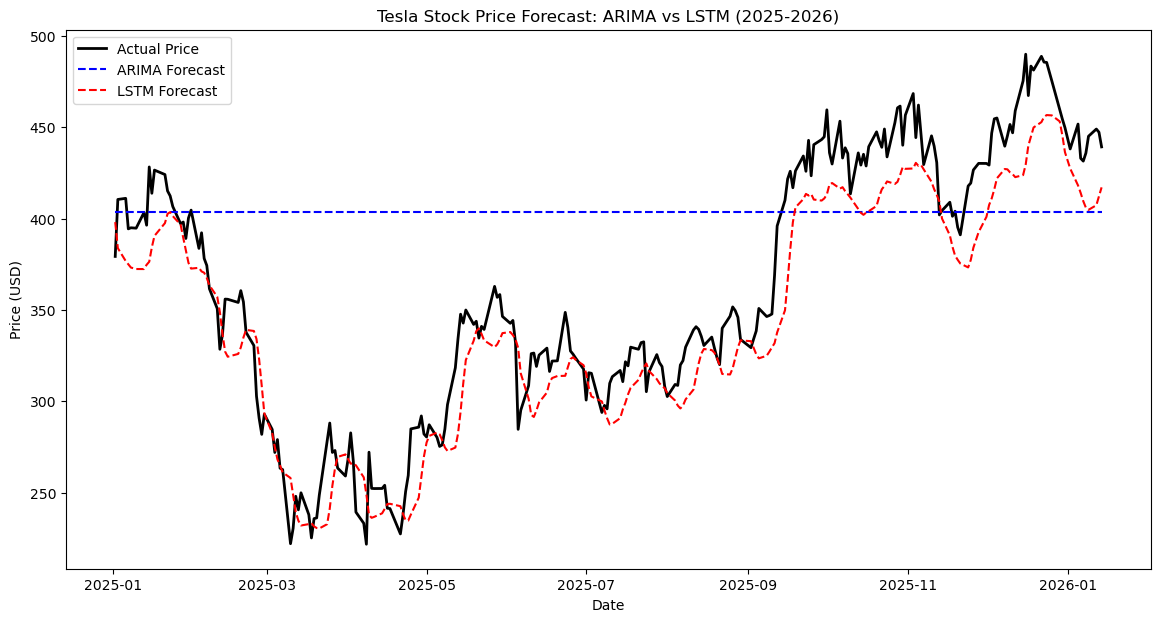

In [7]:


plt.figure(figsize=(14, 7))
plt.plot(test_tsla.index, test_tsla.values, label='Actual Price', color='black', lw=2)
plt.plot(test_tsla.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')
plt.plot(test_tsla.index, lstm_forecast, label='LSTM Forecast', color='red', linestyle='--')

plt.title('Tesla Stock Price Forecast: ARIMA vs LSTM (2025-2026)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [14]:
def generate_recursive_forecast(model, scaler, current_window, steps=126):
    """Generates future predictions by feeding output back as input."""
    future_predictions = []
    # Ensure window is in the correct shape (1, 60, 1)
    last_window = current_window.reshape((1, 60, 1))

    for _ in range(steps):
        # Predict 1 step ahead
        pred = model.predict(last_window, verbose=0)
        future_predictions.append(pred[0])
        
        # Update window: Slide left and add the new prediction to the end
        pred_reshaped = pred.reshape((1, 1, 1))
        last_window = np.append(last_window[:, 1:, :], pred_reshaped, axis=1)

    # Convert scaled values back to USD
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



In [15]:
# Get the last 60 days of the test set to start the future forecast
last_60_days_scaled = my_scaler.transform(test_tsla[-60:])
future_tsla_prices = generate_recursive_forecast(my_lstm_model, my_scaler, last_60_days_scaled)

print(f"Generated {len(future_tsla_prices)} days of future forecast.")

bnd_last_60_days_scaled = bnd_scaler.transform(test_bnd[-60:])
future_bnd_prices = generate_recursive_forecast(bnd_my_lstm_model, bnd_scaler, bnd_last_60_days_scaled)

print(f"Generated {len(future_bnd_prices)} days of future forecast.")

spy_last_60_days_scaled = spy_scaler.transform(test_spy[-60:])
future_spy_prices = generate_recursive_forecast(spy_my_lstm_model, spy_scaler, spy_last_60_days_scaled)

print(f"Generated {len(future_spy_prices)} days of future forecast.")

Generated 126 days of future forecast.
Generated 126 days of future forecast.
Generated 126 days of future forecast.


In [11]:
future_tsla_prices

array([[419.139  ],
       [414.91907],
       [407.5376 ],
       [398.43192],
       [388.49875],
       [378.30417],
       [368.207  ],
       [358.43387],
       [349.12408],
       [340.35782],
       [332.17303],
       [324.57852],
       [317.5616 ],
       [311.09497],
       [305.14194],
       [299.6598 ],
       [294.60345],
       [289.92755],
       [285.58817],
       [281.544  ],
       [277.75717],
       [274.1939 ],
       [270.82437],
       [267.6226 ],
       [264.56665],
       [261.63803],
       [258.8215 ],
       [256.1045 ],
       [253.4769 ],
       [250.93065],
       [248.4593 ],
       [246.0578 ],
       [243.7222 ],
       [241.44925],
       [239.23634],
       [237.0815 ],
       [234.98271],
       [232.93843],
       [230.94722],
       [229.00769],
       [227.11826],
       [225.27776],
       [223.4847 ],
       [221.73764],
       [220.0352 ],
       [218.37595],
       [216.75836],
       [215.18118],
       [213.64282],
       [212.14192],


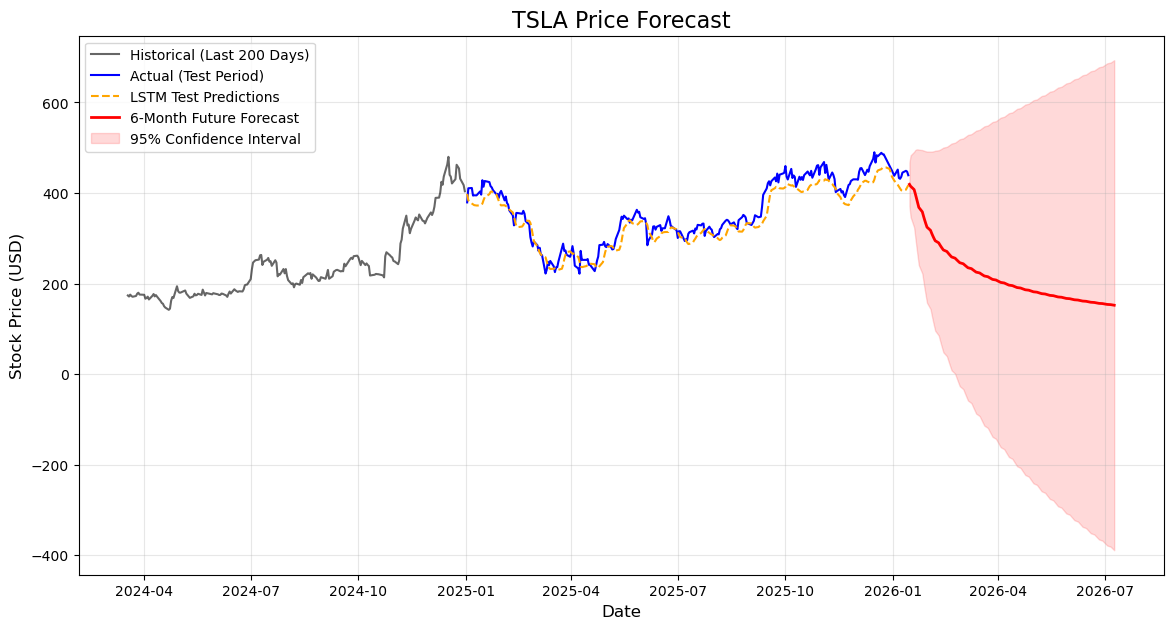

In [12]:
def plot_final_forecast(train, test, test_preds, future_preds, title="TSLA Price Forecast"):
    plt.figure(figsize=(14, 7))
    
    # 1. Plot Historical Training Data
    plt.plot(train.index[-200:], train.values[-200:], label="Historical (Last 200 Days)", color='black', alpha=0.6)
    
    # 2. Plot Test Period (Actual vs Predicted)
    plt.plot(test.index, test.values, label="Actual (Test Period)", color='blue')
    plt.plot(test.index, test_preds, label="LSTM Test Predictions", color='orange', linestyle='--')
    
    # 3. Plot Future Forecast
    # Create a date index for the future (starting the day after test ends)
    future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=len(future_preds), freq='B')
    plt.plot(future_dates, future_preds, label="6-Month Future Forecast", color='red', linewidth=2)
    
    # 4. Add Confidence Intervals (Uncertainty Fan)
    # Estimate uncertainty based on the RMSE of your test predictions
    test_rmse = np.sqrt(np.mean((test.values.flatten() - test_preds.flatten())**2))
    
    # The uncertainty grows over time (square root of time rule)
    uncertainty = [test_rmse * np.sqrt(i+1) for i in range(len(future_preds))]
    lower_bound = future_preds.flatten() - (1.96 * np.array(uncertainty))
    upper_bound = future_preds.flatten() + (1.96 * np.array(uncertainty))
    
    plt.fill_between(future_dates, lower_bound, upper_bound, color='red', alpha=0.15, label="95% Confidence Interval")

    # Formatting
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Stock Price (USD)", fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

# Execution
# Note: Ensure future_tsla_prices is from Task 3.1
plot_final_forecast(train_tsla, test_tsla, lstm_forecast, future_tsla_prices)

TSLA (Forecasted Asset)

In [31]:
# Assuming 'future_tsla_prices' is your 12-month forecast array from Step 1
current_price = test_tsla.values[-1]
forecasted_price_12m = future_tsla_prices[-1]

tsla_expected_return = (forecasted_price_12m / current_price) - 1
print(f"TSLA Expected Annual Return: {tsla_expected_return[0]:.2%}")

TSLA Expected Annual Return: -46.50%


BND and SPY (Historical Assets)

In [32]:
# 1. Filter for the three assets we need
assets_to_include = ['TSLA', 'SPY', 'BND']
filtered_df = full_df[full_df['Asset'].isin(assets_to_include)]

# 2. Pivot the data: Index = Date, Columns = Asset, Values = Adj Close
historical_data = filtered_df.pivot(index='Date', columns='Asset', values='Adj Close')

# 3. Clean up: Drop any rows with missing values (common in merged datasets)
historical_data = historical_data.dropna()

print("Historical Data (Wide Format) Preview:")
print(historical_data.head())

Historical Data (Wide Format) Preview:
Asset             BND         SPY       TSLA
Date                                        
2015-01-02  60.385967  170.589630  14.620667
2015-01-05  60.561333  167.508820  14.006000
2015-01-06  60.736710  165.931061  14.085333
2015-01-07  60.773212  167.998734  14.063333
2015-01-08  60.678207  170.979919  14.041333


In [33]:
# Calculate daily percentage change
daily_returns = historical_data.pct_change().dropna()

# Annualize the historical average returns (assuming 252 trading days)
# Annual Return = (1 + Mean Daily Return)^252 - 1
historical_annual_returns = (1 + daily_returns.mean())**252 - 1

spy_expected_return = historical_annual_returns['SPY']
bnd_expected_return = historical_annual_returns['BND']

print(f"SPY Annualized Historical Return: {spy_expected_return:.2%}")
print(f"BND Annualized Historical Return: {bnd_expected_return:.2%}")

SPY Annualized Historical Return: 15.35%
BND Annualized Historical Return: 2.06%


In [34]:
# Ensure you have tsla_expected_return calculated from your LSTM forecast earlier
expected_returns = pd.Series({
    'TSLA': tsla_expected_return, # From Task 3 LSTM
    'SPY': spy_expected_return,   # From Historical Data
    'BND': bnd_expected_return    # From Historical Data
})

print("\nFinal Expected Returns Vector:")
print(expected_returns)


Final Expected Returns Vector:
TSLA    [-0.4650087696343992]
SPY                   0.15351
BND                  0.020643
dtype: object


Compute Covariance Matrix

In [35]:
# 1. Calculate the Covariance Matrix on daily returns
# This gives you the 'Daily' relationship
daily_cov_matrix = daily_returns.cov()

# 2. Annualize the Covariance Matrix
# Rule: Covariance scales linearly with time (252 days)
annual_cov_matrix = daily_cov_matrix * 252

print("Annualized Covariance Matrix:")
print(annual_cov_matrix)

Annualized Covariance Matrix:
Asset       BND       SPY      TSLA
Asset                              
BND    0.002869  0.001013  0.001667
SPY    0.001013  0.031569  0.050172
TSLA   0.001667  0.050172  0.332840


Generate the Efficient Frontier

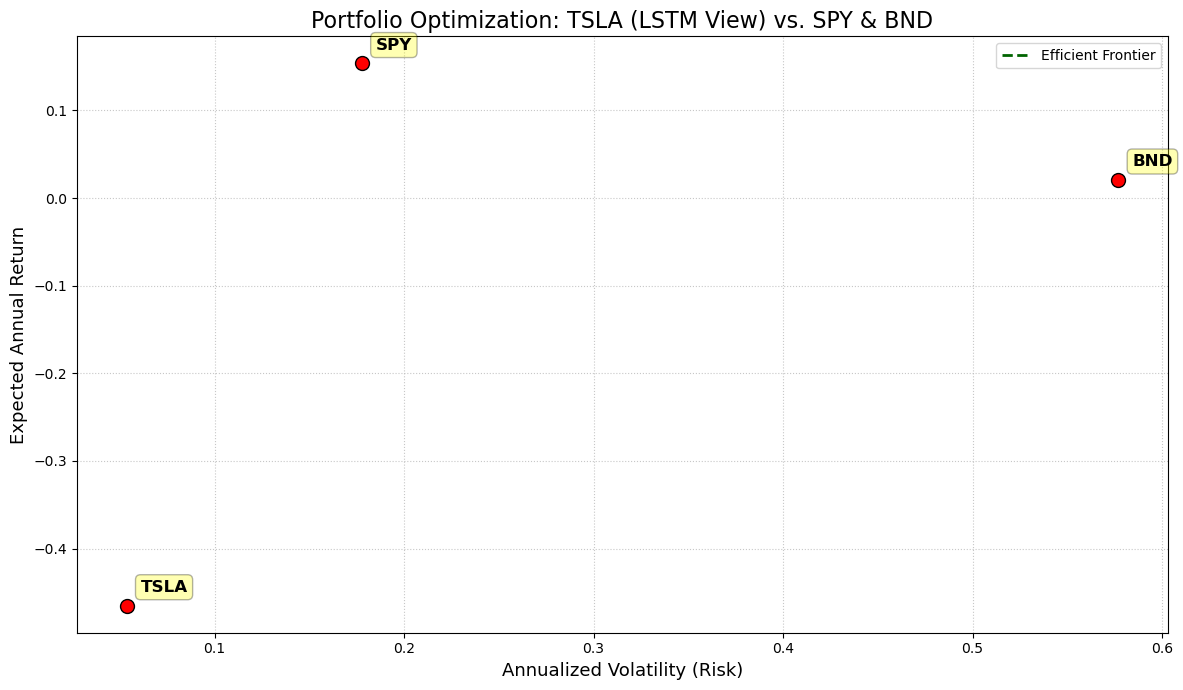

In [37]:
# 1. Setup the basic Efficient Frontier object
ef = EfficientFrontier(expected_returns, annual_cov_matrix)

# 2. Generate the curve points manually to avoid CVXPY/NumPy conflicts
risks, returns = [], []
# We sweep through possible returns to find the minimum risk for each
for target_return in np.linspace(expected_returns.min(), expected_returns.max(), 50):
    try:
        # Re-initialize for each point to prevent "consumption" errors
        ef_point = EfficientFrontier(expected_returns, annual_cov_matrix)
        ef_point.efficient_return(target_return)
        perf = ef_point.portfolio_performance()
        risks.append(perf[1])   # Volatility (X-axis)
        returns.append(perf[0]) # Return (Y-axis)
    except:
        continue

# 3. Create the Visualization
plt.figure(figsize=(12, 7))

# Plot the Frontier Line
plt.plot(risks, returns, color='darkgreen', linestyle='--', linewidth=2, label="Efficient Frontier")

# Calculate Volatilities (Standard Deviation) for individual assets
# We use .values.diagonal() to get the numbers and np.sqrt to get Volatility
asset_vols = np.sqrt(np.diag(annual_cov_matrix.values))

# Plot the 3 assets as individual points
plt.scatter(asset_vols, expected_returns.values, color='red', s=100, edgecolors='black', zorder=5)

# 4. FIXED ANNOTATION LOGIC
# We loop through the assets and use their numeric index/values 
# to ensure Matplotlib doesn't see categorical strings as coordinates.
for i, ticker in enumerate(expected_returns.index):
    plt.annotate(
        ticker, 
        xy=(asset_vols[i], expected_returns.values[i]), # Numeric coordinates
        xytext=(10, 10),                                # Offset text by 10 points
        textcoords='offset points', 
        fontsize=12, 
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3) # Make labels readable
    )

# Formatting
plt.title("Portfolio Optimization: TSLA (LSTM View) vs. SPY & BND", fontsize=16)
plt.xlabel("Annualized Volatility (Risk)", fontsize=13)
plt.ylabel("Expected Annual Return", fontsize=13)
plt.legend(loc='best')
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

Visualize and Identify Key Portfolios

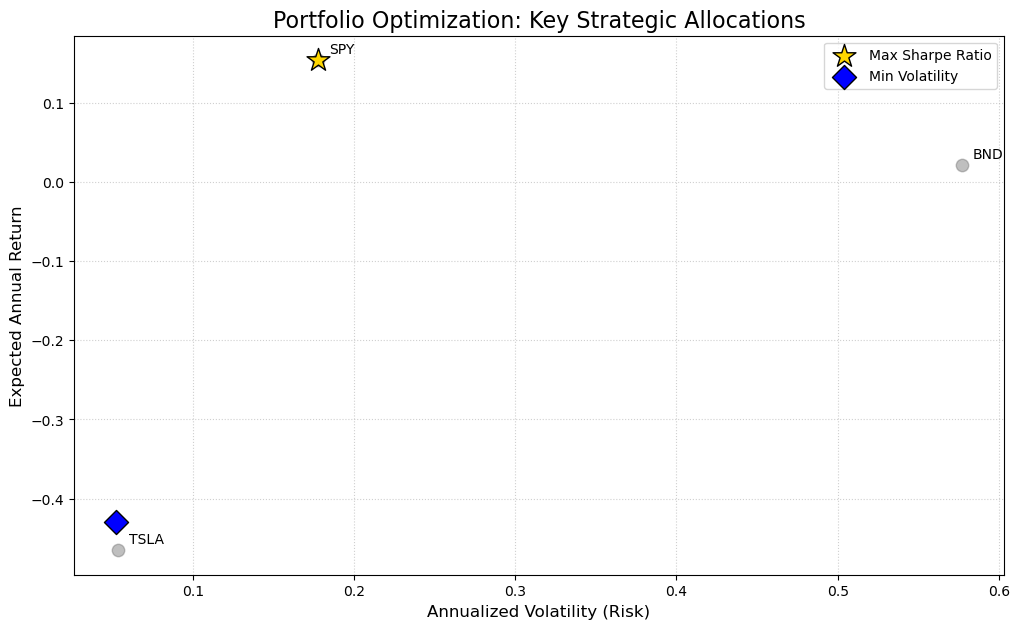

----------------------------------------
MAX SHARPE PORTFOLIO (The Star):
Allocation: OrderedDict([('TSLA', 0.0), ('SPY', 1.0), ('BND', 0.0)])
Return: 15.35%, Risk: 17.77%, Sharpe: 0.75
----------------------------------------
MIN VOLATILITY PORTFOLIO (The Diamond):
Allocation: OrderedDict([('TSLA', 0.94272), ('SPY', 0.05728), ('BND', 0.0)])
Return: -42.96%, Risk: 5.26%, Sharpe: -8.55


In [38]:
# 1. Recalculate Weights
ef_max = EfficientFrontier(expected_returns, annual_cov_matrix)
weights_max = ef_max.max_sharpe()

ef_min = EfficientFrontier(expected_returns, annual_cov_matrix)
weights_min = ef_min.min_volatility()

# 2. FIXED MANUAL PERFORMANCE CALCULATION
def get_performance_scalar(weights, returns, cov):
    w = np.array(list(weights.values()))
    # Calculate and immediately convert to Python float using .item()
    p_return = np.sum(returns.values * w).item()
    p_vol = np.sqrt(np.dot(w.T, np.dot(cov.values, w))).item()
    sharpe = (p_return - 0.02) / p_vol
    return p_return, p_vol, sharpe

# Get numeric performance as pure floats
ret_max, vol_max, shrp_max = get_performance_scalar(weights_max, expected_returns, annual_cov_matrix)
ret_min, vol_min, shrp_min = get_performance_scalar(weights_min, expected_returns, annual_cov_matrix)

# 3. Create the Visualization
plt.figure(figsize=(12, 7))

# Plot the individual assets
asset_vols = np.sqrt(np.diag(annual_cov_matrix.values))
plt.scatter(asset_vols, expected_returns.values, color='grey', s=80, alpha=0.5)

for i, ticker in enumerate(expected_returns.index):
    plt.annotate(ticker, (asset_vols[i], expected_returns.values[i]), xytext=(8,5), textcoords='offset points')

# Mark Key Portfolios
plt.scatter(vol_max, ret_max, marker='*', color='gold', s=300, edgecolors='black', label='Max Sharpe Ratio', zorder=10)
plt.scatter(vol_min, ret_min, marker='D', color='blue', s=150, edgecolors='black', label='Min Volatility', zorder=10)

plt.title("Portfolio Optimization: Key Strategic Allocations", fontsize=16)
plt.xlabel("Annualized Volatility (Risk)", fontsize=12)
plt.ylabel("Expected Annual Return", fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 4. Final Clean Output
print("-" * 40)
print(f"MAX SHARPE PORTFOLIO (The Star):")
print(f"Allocation: {ef_max.clean_weights()}")
print(f"Return: {ret_max:.2%}, Risk: {vol_max:.2%}, Sharpe: {shrp_max:.2f}")
print("-" * 40)
print(f"MIN VOLATILITY PORTFOLIO (The Diamond):")
print(f"Allocation: {ef_min.clean_weights()}")
print(f"Return: {ret_min:.2%}, Risk: {vol_min:.2%}, Sharpe: {shrp_min:.2f}")

In [39]:
# 1. Define the start and end dates
# Ensure your historical_data index is in datetime format
backtest_start = "2025-01-01"
backtest_end = "2026-01-20" # Or your latest date

# 2. Slice the historical returns for the backtesting window
# We use the 'daily_returns' dataframe created in Task 2
backtest_returns = daily_returns.loc[backtest_start:backtest_end]

# 3. Slice the price data (for final value calculation)
backtest_prices = historical_data.loc[backtest_start:backtest_end]

print(f"Backtesting window defined from {backtest_returns.index.min().date()} to {backtest_returns.index.max().date()}")
print(f"Total trading days in backtest: {len(backtest_returns)}")

Backtesting window defined from 2025-01-02 to 2026-01-14
Total trading days in backtest: 259


Define a Benchmark

In [40]:
# 1. Define Benchmark Weights
benchmark_weights = pd.Series({
    'TSLA': 0.0,
    'SPY': 0.60,
    'BND': 0.40
})

# 2. Calculate Benchmark Daily Returns
# We use the backtest_returns from the previous step
benchmark_daily_returns = (backtest_returns * benchmark_weights).sum(axis=1)

# 3. Calculate Cumulative Growth for a $100,000 investment
initial_investment = 100000
benchmark_cumulative_growth = (1 + benchmark_daily_returns).cumprod() * initial_investment

print("Benchmark Portfolio Growth (First 5 days):")
print(benchmark_cumulative_growth.head())

Benchmark Portfolio Growth (First 5 days):
Date
2025-01-02     99869.260099
2025-01-03    100568.509554
2025-01-06    100876.922968
2025-01-07    100052.185901
2025-01-08    100184.659934
dtype: float64


Simulate Your Strategy

In [41]:
# Define Initial Investment
initial_capital = 100000

# 1. Get Daily Returns for your Optimized Portfolios
# Max Sharpe (100% SPY)
max_sharpe_weights = pd.Series({'TSLA': 0.0, 'SPY': 1.0, 'BND': 0.0})
max_sharpe_daily_rets = (backtest_returns * max_sharpe_weights).sum(axis=1)

# Min Volatility (94.3% TSLA / 5.7% SPY)
min_vol_weights = pd.Series({'TSLA': 0.943, 'SPY': 0.057, 'BND': 0.0})
min_vol_daily_rets = (backtest_returns * min_vol_weights).sum(axis=1)

# 2. Calculate Cumulative Growth
# Strategy A: Max Sharpe
max_sharpe_growth = (1 + max_sharpe_daily_rets).cumprod() * initial_capital

# Strategy B: Min Volatility
min_vol_growth = (1 + min_vol_daily_rets).cumprod() * initial_capital

# Strategy C: Benchmark (60/40) - from previous step
benchmark_growth = (1 + benchmark_daily_returns).cumprod() * initial_capital

print("Simulation Complete. Final Portfolio Values:")
print(f"Max Sharpe (100% SPY): ${max_sharpe_growth.iloc[-1]:,.2f}")
print(f"Min Volatility (TSLA-Heavy): ${min_vol_growth.iloc[-1]:,.2f}")
print(f"Benchmark (60/40): ${benchmark_growth.iloc[-1]:,.2f}")

Simulation Complete. Final Portfolio Values:
Max Sharpe (100% SPY): $119,176.05
Min Volatility (TSLA-Heavy): $110,133.06
Benchmark (60/40): $114,920.84


Analyze Performance

In [42]:
def calculate_metrics(cum_growth, daily_returns, name):
    # 1. Total Return
    total_return = (cum_growth.iloc[-1] / cum_growth.iloc[0]) - 1
    
    # 2. Annualized Return (assuming 252 trading days)
    ann_return = (1 + total_return)**(252 / len(cum_growth)) - 1
    
    # 3. Sharpe Ratio (assuming 2% risk-free rate)
    ann_vol = daily_returns.std() * np.sqrt(252)
    sharpe = (ann_return - 0.02) / ann_vol
    
    # 4. Maximum Drawdown
    # Max drop from a previous peak
    rolling_max = cum_growth.cummax()
    drawdown = (cum_growth - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    return {
        "Strategy": name,
        "Total Return": f"{total_return:.2%}",
        "Annualized Return": f"{ann_return:.2%}",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_drawdown:.2%}"
    }

# Calculate for all three
metrics_max_sharpe = calculate_metrics(max_sharpe_growth, max_sharpe_daily_rets, "Max Sharpe (100% SPY)")
metrics_min_vol = calculate_metrics(min_vol_growth, min_vol_daily_rets, "Min Vol (TSLA-Heavy)")
metrics_benchmark = calculate_metrics(benchmark_growth, benchmark_daily_returns, "60/40 Benchmark")

# Display results in a DataFrame
results_df = pd.DataFrame([metrics_max_sharpe, metrics_min_vol, metrics_benchmark])
print(results_df)

                Strategy Total Return Annualized Return Sharpe Ratio  \
0  Max Sharpe (100% SPY)       19.47%            18.90%         0.88   
1   Min Vol (TSLA-Heavy)       16.85%            16.36%         0.24   
2        60/40 Benchmark       15.07%            14.64%         1.07   

  Max Drawdown  
0      -18.76%  
1      -46.62%  
2      -11.29%  
